In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, matthews_corrcoef, f1_score
)
from imblearn.over_sampling import SMOTE
import numpy as np

import os
from torch.utils.data import random_split, DataLoader
from collections import Counter

In [2]:
# Define Dataset Class
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)

        # Handle missing values
        self.data.fillna(self.data.mean(), inplace=True)

        # Separate features and labels
        self.features = self.data.iloc[:, 1:]
        self.labels = self.data.iloc[:, 0].astype(int)

        # Normalize features
        scaler = StandardScaler()
        self.features = pd.DataFrame(scaler.fit_transform(self.features), columns=self.features.columns)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.features.iloc[idx].values.astype(np.float32)
        label = int(self.labels.iloc[idx])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Define CNN Model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16) 
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)  
        self.fc1 = nn.Linear(32 * input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # x = x.unsqueeze(1)  # Add channel dimension (N, 1, input_size)
        # x = self.relu(self.bn1(self.conv1(x)))  # Apply batch normalization
        # x = self.relu(self.bn2(self.conv2(x)))
        # x = x.flatten(1)  # Flatten for fully connected layers
        # x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = self.fc2(x)
        x = x.unsqueeze(1)  # Add channel dimension (N, 1, input_size)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)  # Flatten for fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Simplified CNN Model
class SimplifiedCNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimplifiedCNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1)  # Reduced from 16 to 8 filters
        # self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=3, stride=1, padding=1)  # Reduced from 32 to 16 filters
        # self.bn1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16 * input_size, 64)  # Reduced fully connected layer size
        self.fc2 = nn.Linear(64, num_classes)  # Output layer remains the same
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)  # Adjust dropout rate to prevent overfitting
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (N, 1, input_size)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)  # Flatten for fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total

        # Validation Loop
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        
        # Switch back to training mode
        model.train()

        # Print metrics for the epoch
        # print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, "
        #       f"Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")


In [3]:

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class
            predictions = (probabilities >= 0.5).long()  # Apply threshold
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions.numpy())
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_predictions))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1"]))

In [50]:
#  Load dataset
from collections import Counter
# torch.manual_seed(42)
def oversampledCNN(csv_file):
    dataset = CSVDataset(csv_file)

    # Train-test split
    train_size = int(0.8 * len(dataset))
    eval_size = len(dataset) - train_size
    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

    # Prepare train and test features/labels for SMOTE
    X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
    y_train = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])

    # # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Check label distribution after SMOTE
    print("Label distribution after SMOTE:")
    print(Counter(y_train_resampled))

    train_dataset = [(torch.tensor(X_train_resampled[i], dtype=torch.float32),
                      torch.tensor(y_train_resampled[i], dtype=torch.long)) 
                     for i in range(len(y_train_resampled))]

    eval_dataset = [(torch.tensor(eval_dataset[i][0].numpy(), dtype=torch.float32),
                    eval_dataset[i][1]) 
                    for i in range(len(eval_dataset))]

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

    # Model initialization
    input_size = dataset.features.shape[1]  # Automatically adapts to the number of features
    num_classes = 2  # Binary classification
    model = CNN1D(input_size=input_size, num_classes=num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, test_loader, optimizer, criterion, epochs=50)
    evaluate_model(model, test_loader)

def originalCNN(csv_file):
    dataset = CSVDataset(csv_file)

    # Train-test split
    train_size = int(0.8 * len(dataset))
    eval_size = len(dataset) - train_size
    train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

    # Prepare train and test features/labels for SMOTE
    X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
    y_train = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])

    train_dataset = [(torch.tensor(X_train[i], dtype=torch.float32),
                    torch.tensor(y_train[i], dtype=torch.long)) 
                    for i in range(len(y_train))]

    eval_dataset = [(torch.tensor(eval_dataset[i][0].numpy(), dtype=torch.float32),
                    eval_dataset[i][1]) 
                    for i in range(len(eval_dataset))]

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

    # Model initialization
    input_size = dataset.features.shape[1]  # Automatically adapts to the number of features
    num_classes = 2  # Binary classification
    model = CNN1D(input_size=input_size, num_classes=num_classes)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, test_loader, optimizer, criterion, epochs=50)
    evaluate_model(model, test_loader)
    
csv_file = "data/merged_data/no_personality/filtered_merged_5seconds_middle.csv"   # Replace with your file path
oversampledCNN(csv_file)
originalCNN(csv_file)

Label distribution after SMOTE:
Counter({0: 1269, 1: 1269})
Confusion Matrix:
[[294  21]
 [ 26  72]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.93      0.93       315
     Class 1       0.77      0.73      0.75        98

    accuracy                           0.89       413
   macro avg       0.85      0.83      0.84       413
weighted avg       0.88      0.89      0.89       413

Confusion Matrix:
[[296  14]
 [ 35  68]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.95      0.92       310
     Class 1       0.83      0.66      0.74       103

    accuracy                           0.88       413
   macro avg       0.86      0.81      0.83       413
weighted avg       0.88      0.88      0.88       413



In [7]:

def extract_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy_score(y_true, y_pred),
        'MCC': matthews_corrcoef(y_true, y_pred),
        'F1_macro': f1_score(y_true, y_pred, average='macro'),
        'F1_weighted': f1_score(y_true, y_pred, average='weighted')
    }

def evaluate_model_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return extract_metrics(all_labels, all_preds)

def oversampledCNN(csv_file, n_runs=30):
    results = []

    for run in range(n_runs):
        print("Run: ", run)
        dataset = CSVDataset(csv_file)
         # Prepare train and test features/labels for SMOTE
        X = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
        y= np.array([dataset[i][1].item() for i in range(len(dataset))])

        train_size = int(0.8 * len(dataset))
        eval_size = len(dataset) - train_size
        X_train, X_eval, y_train, y_eval  = train_test_split(X, y, test_size=0.2, random_state = 42)

        # X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
        # y_train = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])

        try:
            X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
        except ValueError as e:
            print(f"Run {run}: SMOTE failed with: {e}")
            continue
        
        print(Counter(y_train_resampled))
        train_dataset = [(torch.tensor(X_train_resampled[i], dtype=torch.float32),
                          torch.tensor(y_train_resampled[i], dtype=torch.long)) 
                         for i in range(len(y_train_resampled))]

        eval_dataset = [(torch.tensor(X_eval[i], dtype=torch.float32),
                          torch.tensor(y_eval[i], dtype=torch.long)) 
                         for i in range(len(y_eval))]

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

        input_size = dataset.features.shape[1]
        model = CNN1D(input_size=input_size, num_classes=2)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_model(model, train_loader, test_loader, optimizer, criterion, epochs=50)
        metrics = evaluate_model_metrics(model, test_loader)
        metrics['Run'] = run + 1
        results.append(metrics)

    df = pd.DataFrame(results)
    parent = os.path.basename(os.path.dirname(csv_file))
    # filename = os.path.splitext(os.path.basename(csv_file))[0]
    # tag = f"{parent}_{filename}"
    df.to_csv(f"results/{parent}_oversampled_cnn_metrics.csv", index=False)
    print(f"\n[Oversampled CNN] Avg Accuracy over {n_runs} runs: {df['Accuracy'].mean():.4f}")

def originalCNN(csv_file, n_runs=30):
    results = []

    for run in range(n_runs):
        print("Run: ", run)
        dataset = CSVDataset(csv_file)
        X = np.array([dataset[i][0].numpy() for i in range(len(dataset))])
        y= np.array([dataset[i][1].item() for i in range(len(dataset))])
        
        train_size = int(0.8 * len(dataset))
        eval_size = len(dataset) - train_size
        X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)  # random_state=42 if you want reproducibility

        # X_train = np.array([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
        # y_train = np.array([train_dataset[i][1].item() for i in range(len(train_dataset))])
        print(Counter(y_train))
        train_dataset = [(torch.tensor(X_train[i], dtype=torch.float32),
                          torch.tensor(y_train[i], dtype=torch.long)) 
                         for i in range(len(y_train))]
        
        eval_dataset = [(torch.tensor(X_eval[i], dtype=torch.float32),
                          torch.tensor(y_eval[i], dtype=torch.long)) 
                         for i in range(len(y_eval))]

        # eval_dataset = [(torch.tensor(eval_dataset[i][0].numpy(), dtype=torch.float32),
        #                  eval_dataset[i][1]) 
        #                 for i in range(len(eval_dataset))]

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)

        input_size = dataset.features.shape[1]
        model = CNN1D(input_size=input_size, num_classes=2)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_model(model, train_loader, test_loader, optimizer, criterion, epochs=50)
        metrics = evaluate_model_metrics(model, test_loader)
        metrics['Run'] = run + 1
        results.append(metrics)

    df = pd.DataFrame(results)
    parent = os.path.basename(os.path.dirname(csv_file))
    # filename = os.path.splitext(os.path.basename(csv_file))[0]
    # tag = f"{parent}_{filename}"
    df.to_csv(f"results/{parent}_original_cnn_metrics.csv", index=False)
    print(f"\n[Original CNN] Avg Accuracy over {n_runs} runs: {df['Accuracy'].mean():.4f}")
    
    
def runexperiments(file_extension):
    os.makedirs("results", exist_ok=True)

    all_data = "data/merged_data/all/" + file_extension
    no_sensor = "data/merged_data/no_sensor/" + file_extension
    no_fixation = "data/merged_data/no_fixation/" + file_extension
    no_saccade = "data/merged_data/no_saccade/" + file_extension
    no_velocity = "data/merged_data/no_velocity/" + file_extension
    no_distance = "data/merged_data/no_distance/" + file_extension
    no_personality = "data/merged_data/no_personality/" + file_extension

    data_list = [all_data]
    # data_list = [no_sensor, no_fixation, no_saccade, no_velocity, no_distance, no_personality]
    for data in data_list:
        oversampledCNN(data)
        originalCNN(data)

runexperiments("filtered_merged_5seconds_middle.csv")


Run:  0
Counter({1: 1265, 0: 1265})
Run:  1
Counter({1: 1265, 0: 1265})
Run:  2
Counter({1: 1265, 0: 1265})
Run:  3
Counter({1: 1265, 0: 1265})
Run:  4
Counter({1: 1265, 0: 1265})
Run:  5
Counter({1: 1265, 0: 1265})
Run:  6
Counter({1: 1265, 0: 1265})
Run:  7
Counter({1: 1265, 0: 1265})
Run:  8
Counter({1: 1265, 0: 1265})
Run:  9
Counter({1: 1265, 0: 1265})
Run:  10
Counter({1: 1265, 0: 1265})
Run:  11
Counter({1: 1265, 0: 1265})
Run:  12
Counter({1: 1265, 0: 1265})
Run:  13
Counter({1: 1265, 0: 1265})
Run:  14
Counter({1: 1265, 0: 1265})
Run:  15
Counter({1: 1265, 0: 1265})
Run:  16
Counter({1: 1265, 0: 1265})
Run:  17
Counter({1: 1265, 0: 1265})
Run:  18
Counter({1: 1265, 0: 1265})
Run:  19
Counter({1: 1265, 0: 1265})
Run:  20
Counter({1: 1265, 0: 1265})
Run:  21
Counter({1: 1265, 0: 1265})
Run:  22
Counter({1: 1265, 0: 1265})
Run:  23
Counter({1: 1265, 0: 1265})
Run:  24
Counter({1: 1265, 0: 1265})
Run:  25
Counter({1: 1265, 0: 1265})
Run:  26
Counter({1: 1265, 0: 1265})
Run:  27
Co

All probabilities are within the range [0, 1].


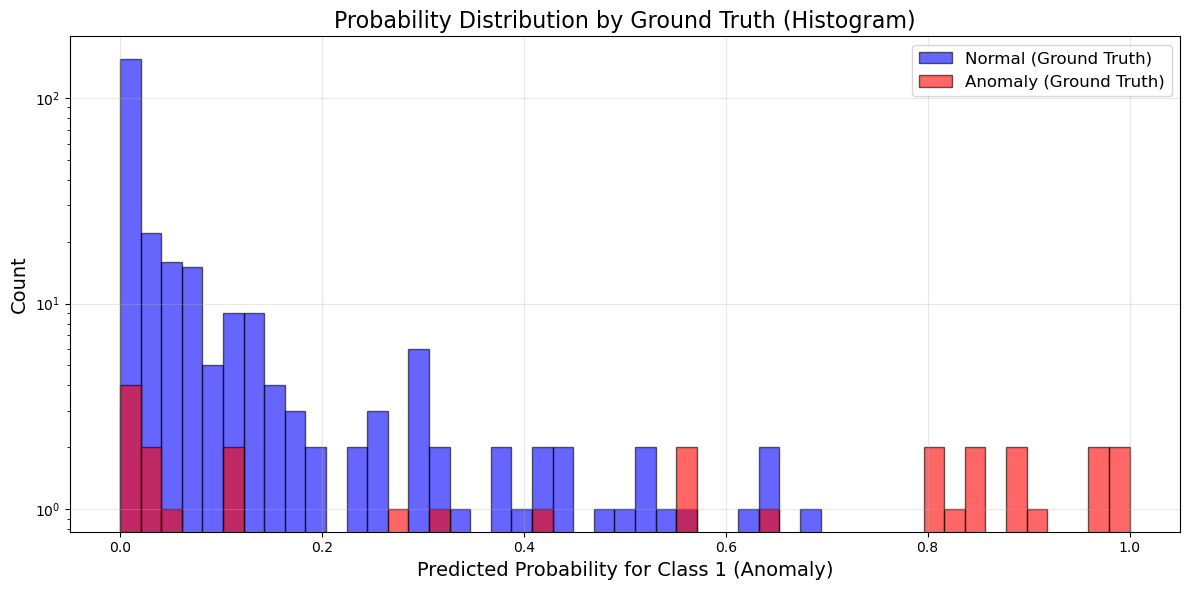

All probabilities are within the range [0, 1].


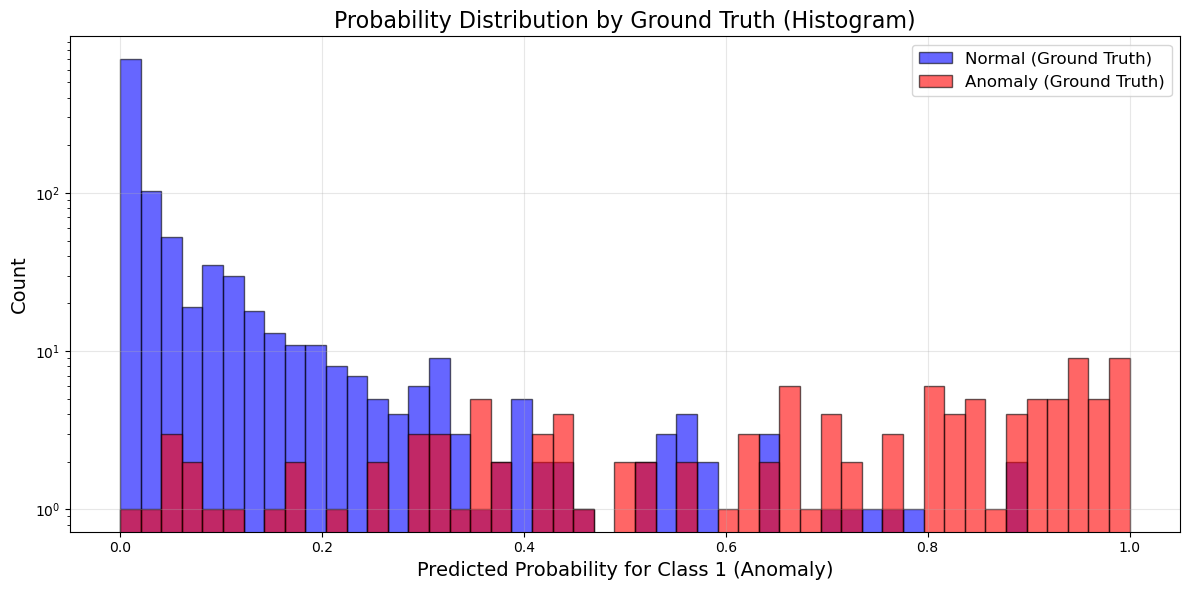

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

def visualize_probabilities(model, test_loader):
    model.eval()
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            probabilities = F.softmax(outputs, dim=1)[:, 1]  # Get probabilities for Class 1 (Anomaly)
            all_probabilities.extend(probabilities.numpy())
            all_labels.extend(labels.numpy())
            
    if np.all((np.array(all_probabilities) >= 0) & (np.array(all_probabilities) <= 1)):
        print("All probabilities are within the range [0, 1].")
    else:
        print("Some probabilities are outside the range [0, 1].")


    # Separate probabilities by ground truth labels
    normal_probs = [p for p, l in zip(all_probabilities, all_labels) if l == 0]
    anomaly_probs = [p for p, l in zip(all_probabilities, all_labels) if l == 1]

    # Plot the histograms
    plt.figure(figsize=(12, 6))

    # Use finer bins for smaller intervals
    bins = np.linspace(0, 1, 50)  # Increased bins for finer intervals

    plt.hist(normal_probs, bins=bins, alpha=0.6, label="Normal (Ground Truth)", color="blue", edgecolor='black')
    plt.hist(anomaly_probs, bins=bins, alpha=0.6, label="Anomaly (Ground Truth)", color="red", edgecolor='black')

    # Add labels, title, and legend
    plt.title("Probability Distribution by Ground Truth (Histogram)", fontsize=16)
    plt.xlabel("Predicted Probability for Class 1 (Anomaly)", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.yscale("log")  # Use logarithmic scale to highlight smaller counts
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()
visualize_probabilities(model, test_loader)
visualize_probabilities(model, train_loader)
